#Introduction


---


Starting from the fact nowadays I'm looking and studying all the information about the estimation and the modelling of the operational risk and after some useful statistics recap and some useful readings, I had an idea and here I am.

So, this work focuses on operational risk.

Since the datasets are not at a free disposal of users, I have decided to create a fake dataset, simulating a scenario for applying this model.

The df includes:
- **event_id** that is the id of the possible event;
- **event_type**, including frauds, process errors,
- **event_date** that is the date in which the event occurs;
- **business_line**;
- **loss amount**.
It has 1000 occurred events.

Recall that the operational risk analysis is an analysis performed to see all the riskier events occured in the ordinary aplication of the business processes, like frauds or process errors.

They were included thanks Basel II framework, to not only consider credit and market risk, but even operational risks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from scipy.optimize import newton
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.special import digamma

In [2]:
df= pd.read_csv("operational_risk_full.csv", index_col=0)
df

,event_date,event_type,business_line,loss_amount
event_id,,,,
0,2021-01-01,Process Error,Retail Banking,5177.701001
1,2021-01-02,External Fraud,Retail Banking,31519.032973
2,2021-01-03,Process Error,Asset Management,25855.827741
3,2021-01-04,Process Error,Corporate Finance,5051.113305
4,2021-01-05,External Fraud,Retail Banking,3664.655641
...,...,...,...,...
995,2023-09-23,Internal Fraud,Retail Banking,5133.540905
996,2023-09-24,Process Error,Asset Management,57457.231187
997,2023-09-25,Internal Fraud,Corporate Finance,4847.530164


#Explanatory analysis
The next step is performing explanatory analysis.

Thanks to the method `info()` I'm able to extract general information from the df, like if there are null values, the dtype of the columns and how many entries we have.



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_date     1000 non-null   object 
 1   event_type     1000 non-null   object 
 2   business_line  1000 non-null   object 
 3   loss_amount    1000 non-null   float64
dtypes: float64(1), object(3)
memory usage: 39.1+ KB


Additional step is looking at the boxplot of the column loss amount in order to gather information on the variability and as we can see there is a high severity, classical charateristic of the operational risk.


<Axes: >

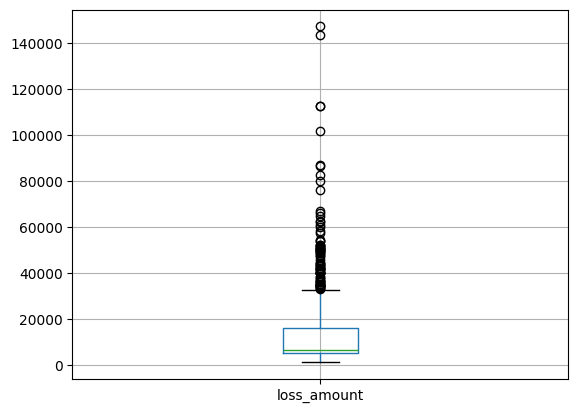

In [4]:
df.boxplot(column='loss_amount')

Then, the method describe is necessary in order to calculate mean, std, interquantile range and the general variability.

- For loss amount, as we could imagine, the variability is elevated meaning that the df alternates high values to very low values (low severity, high severity);

- If we group by the event type and then we use describe, we get the variability for each event type and the process error is the most variable. In addition if we look at count, we can easily determine that the most frequent risk is process error again.

In [5]:
df.describe()

,loss_amount
count,1000.000000
mean,12982.960916
std,14968.668618
min,1000.000000
25%,4952.881727
50%,6323.273298
75%,16098.830605
max,147437.937075


In [6]:
df.groupby('event_type').describe()

loss_amount                                           \
                     count          mean           std          min   
event_type                                                            
External Fraud       321.0  12828.145673  14311.868915  1000.000000   
Internal Fraud       355.0  13163.594997  14820.630146  1349.976796   
Process Error        324.0  12938.425715  15788.374914  1000.000000   

                                                                       
                        25%          50%           75%            max  
event_type                                                             
External Fraud  4962.777763  6401.636714  16398.255034  143584.201416  
Internal Fraud  4918.566121  6364.140430  14664.290675  101848.549555  
Process Error   4963.758266  6188.704902  16017.424062  147437.937075

Moreover, this histogram shows the possible distribution of the loss amount and we can easily see that the highest frequency is between 0 and 20.000, then it plummets.


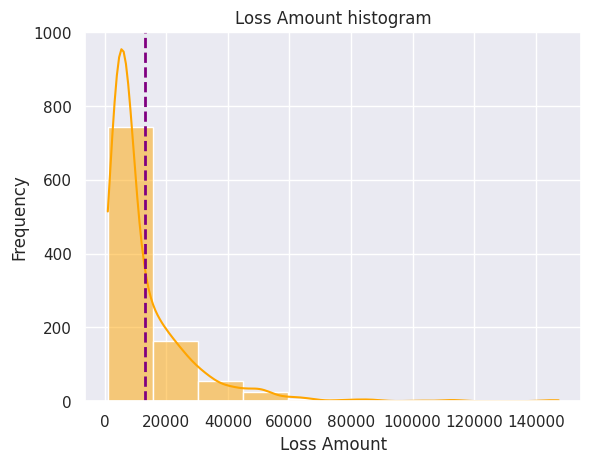

In [7]:
sns.set_theme(style="darkgrid")
sns.histplot(df['loss_amount'], kde=True, alpha=0.5, bins=10, color="orange")
plt.axvline(df['loss_amount'].mean(), color='purple', linestyle='dashed', linewidth=2)
plt.title("Loss Amount histogram")
plt.xlabel("Loss Amount")
plt.ylabel("Frequency")
plt.show()


#Unsupervised learning methods
Having said so, it looms the df has got two important sides: low-frequency, high severity events and high-frequency but low severity events.

For that reason, I've decided to apply an initial clustering technique for splitting the data into different groups and then using the mixed distribution for modelling it.

Unsupervised learning is a branch of machine learning that deals with finding patterns in data without explicit labels. Clustering is a prominent unsupervised learning task that groups similar data points together. Here's an overview of common unsupervised learning methods for clustering, how they work, and when to use them:

## K-Means Clustering

### How it Works:
K-Means is an iterative algorithm that partitions data into *k* pre-defined clusters. The core idea is to:
1.  **Initialization:** Randomly select *k* data points as initial cluster centroids.
2.  **Assignment:** Assign each data point to the closest centroid, forming *k* clusters.
3.  **Update:** Recalculate the centroids as the mean of all data points assigned to that cluster.
4.  **Iteration:** Repeat steps 2 and 3 until the centroids no longer change significantly or a maximum number of iterations is reached.

### When to Use:
*   **Known Number of Clusters:** When you have a prior idea of how many clusters you expect in your data.
*   **Large Datasets:** K-Means is computationally efficient and scales well to large datasets.
*   **Spherical Clusters:** It works best when clusters are relatively spherical and similarly sized.
*   **Ease of Implementation:** It's straightforward to understand and implement.

### When Not to Use:
*   **Varying Cluster Shapes/Densities:** Struggles with irregularly shaped clusters or clusters of vastly different densities.
*   **Outliers:** Sensitive to outliers, which can significantly shift cluster centroids.
*   **Categorical Data:** Not directly applicable to categorical data; requires encoding.

---

## Hierarchical Clustering

### How it Works:
Hierarchical clustering builds a hierarchy of clusters. There are two main approaches:

1.  **Agglomerative (Bottom-Up):**
    *   Starts with each data point as its own cluster.
    *   Iteratively merges the closest pairs of clusters until all data points are in a single cluster or a stopping criterion is met.
    *   The "closeness" between clusters is determined by a linkage criterion (e.g., single linkage, complete linkage, average linkage, Ward's method).
    *   The result is a dendrogram, which visualizes the merging process.

2.  **Divisive (Top-Down):**
    *   Starts with all data points in one cluster.
    *   Recursively splits the most heterogeneous clusters until each data point is in its own cluster. (Less common in practice).

### When to Use:
*   **Unknown Number of Clusters:** When you don't know the optimal number of clusters beforehand, as the dendrogram helps in determining this.
*   **Understanding Cluster Structure:** When you want to visualize the hierarchical relationships between clusters.
*   **Small to Medium Datasets:** Can be computationally intensive for very large datasets.
*   **Irregular Cluster Shapes:** Can handle non-spherical clusters better than K-Means, depending on the linkage method.

### When Not to Use:
*   **Very Large Datasets:** The computational complexity can be high, making it slow for massive datasets.
*   **Ambiguous Linkage:** The choice of linkage criterion can significantly impact the results, and sometimes it's not clear which one is best.

---

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### How it Works:
DBSCAN groups together data points that are closely packed together, marking as outliers those points that lie alone in low-density regions. It defines clusters based on two parameters:
*   `eps` (epsilon): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
*   `min_samples`: The number of samples in a neighborhood for a point to be considered as a core point.

The algorithm works as follows:
1.  **Core Point:** A point is a core point if it has at least `min_samples` within a distance of `eps`.
2.  **Border Point:** A point is a border point if it is within `eps` distance of a core point but has less than `min_samples` within its own `eps` neighborhood.
3.  **Noise Point:** A point is a noise point (outlier) if it is neither a core point nor a border point.
4.  DBSCAN then connects core points that are within `eps` of each other and expands these connections to include border points, forming clusters.

### When to Use:
*   **Arbitrary Cluster Shapes:** Excellent at discovering clusters of arbitrary shapes, unlike K-Means.
*   **Noise Detection:** Automatically identifies and labels outliers (noise points).
*   **Varying Cluster Densities:** Can handle clusters of different densities, though tuning `eps` and `min_samples` can be tricky.
*   **Unknown Number of Clusters:** Does not require the number of clusters to be specified beforehand.

### When Not to Use:
*   **Varying Densities (Challenging):** While it can handle varying densities to some extent, a single set of `eps` and `min_samples` might not work well for all clusters if densities vary drastically.
*   **High-Dimensional Data:** Performance can degrade in very high-dimensional spaces due to the "curse of dimensionality," where distances become less meaningful.
*   **Parameter Sensitivity:** Sensitive to the choice of `eps` and `min_samples`; selecting optimal values can be challenging.

---


## Gaussian Mixture Models (GMMs)

### How it Works:
GMMs assume that the data points are generated from a mixture of several Gaussian distributions with unknown parameters (mean, covariance, and mixing proportions). Instead of assigning each data point to a single cluster, GMMs provide a probability that each point belongs to each cluster.

The algorithm uses an iterative Expectation-Maximization (EM) algorithm:
1.  **Initialization:** Randomly initialize the parameters (mean, covariance, and mixing weights) for *k* Gaussian components.
2.  **Expectation (E-step):** Calculate the probability (responsibility) that each data point belongs to each component, given the current parameters.
3.  **Maximization (M-step):** Update the parameters of each Gaussian component to maximize the likelihood of the data, based on the responsibilities calculated in the E-step.
4.  **Iteration:** Repeat E and M steps until convergence.

### When to Use:
*   **Overlapping Clusters:** When clusters are not clearly separated and might overlap, as GMMs provide soft assignments (probabilities).
*   **Non-Spherical Clusters:** Can model elliptical or elongated clusters by allowing for different covariance matrices.
*   **Probabilistic Assignments:** When you need a measure of uncertainty or confidence for each data point's cluster assignment.
*   **Estimating Data Distribution:** Useful for understanding the underlying generative process of the data.

### When Not to Use:
*   **Computational Cost:** Can be more computationally expensive than K-Means, especially with a large number of components or high-dimensional data.
*   **Local Optima:** The EM algorithm can converge to a local optimum, so multiple initializations might be necessary.
*   **Number of Components:** Requires specifying the number of components (clusters) beforehand, though information criteria like BIC or AIC can help.


**Chosen model**:

For teh sake of simplicity, I'm going to apply k-means.

I'm taking it that the number of clusters are two, according the general behaviour of operational risk df.
The first step is performing one-hot encoding for treating the categorical variable. In particular, I'm going to use `pd.get_dummies` for a direct change of the df.


In [8]:
from sklearn.cluster import KMeans

In [9]:
df_copy=df.copy()
df_copy=pd.get_dummies(df_copy, columns=['event_type','event_date','business_line'])
df_copy

,loss_amount,event_type_External Fraud,event_type_Internal Fraud,event_type_Process Error,event_date_2021-01-01,event_date_2021-01-02,event_date_2021-01-03,event_date_2021-01-04,event_date_2021-01-05,event_date_2021-01-06,...,event_date_2023-09-21,event_date_2023-09-22,event_date_2023-09-23,event_date_2023-09-24,event_date_2023-09-25,event_date_2023-09-26,event_date_2023-09-27,business_line_Asset Management,business_line_Corporate Finance,business_line_Retail Banking
event_id,,,,,,,,,,,,,,,,,,,,,
0,5177.701001,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,31519.032973,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,25855.827741,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,5051.113305,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,3664.655641,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5133.540905,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
996,57457.231187,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
997,4847.530164,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False


For the kmeans application I have used two clusters and the random state. I have not modified the parameter init (because I can use either kmeans++ or random (kmeans++ is default), but I prefer that the initial centroids have points assigned using probability and not randomly chosen) and neither the algorithm (you can choose between “lloyd” or “elkan”, i prefer lloyd for straightforward implementation)

In [10]:
kmeans=KMeans(n_clusters=2,random_state=42)
kmeans.fit(df_copy)

KMeans(n_clusters=2, random_state=42)

In [11]:
df_copy["clusters"]=kmeans.labels_

In [12]:
df_copy

,loss_amount,event_type_External Fraud,event_type_Internal Fraud,event_type_Process Error,event_date_2021-01-01,event_date_2021-01-02,event_date_2021-01-03,event_date_2021-01-04,event_date_2021-01-05,event_date_2021-01-06,...,event_date_2023-09-22,event_date_2023-09-23,event_date_2023-09-24,event_date_2023-09-25,event_date_2023-09-26,event_date_2023-09-27,business_line_Asset Management,business_line_Corporate Finance,business_line_Retail Banking,clusters
event_id,,,,,,,,,,,,,,,,,,,,,
0,5177.701001,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0
1,31519.032973,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
2,25855.827741,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,0
3,5051.113305,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,0
4,3664.655641,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5133.540905,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,0
996,57457.231187,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,1
997,4847.530164,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,0


Then, I have decided to introduce a new column called high_severity that satisfies two conditions: being cluster 1 and at the same time the loss amount should be greater than > 10000.


In [13]:
df_copy["high_severity"] = (df_copy["loss_amount"] > 10000) & (df_copy["clusters"] == 1)

The successive steps are using the df in order to understand which mixture model is able to capture the loss distribution.

#Mixture distribution
As guess I have decided to work with lognormal and gamma distribution, both of them continuous.

So, first of all we need to calculate the parameters as initial guess in order to apply the algorithm called Expectation-Maximization.


### Lognormal Distribution

The **lognormal distribution** models continuous random variables whose logarithm is normally distributed. If $ X \sim \text{Lognormal}(\mu, \sigma) $, then $ \ln X \sim \mathcal{N}(\mu, \sigma^2) $.

- **Parameters:**
  - $\mu $ (location): Mean of the variable's natural logarithm.
  - $ \sigma $ (scale): Standard deviation of the variable's natural logarithm.
  - Support: $ x > 0 $, $ \sigma > 0 $, $ -\infty < \mu < \infty $.

- **Parameter Estimation:**
  - Given data $ x_1, ..., x_n $, estimate $ \mu $ and $ \sigma $ by:
    1. Compute $ y_i = \ln x_i $ for each observation.
    2. $ \hat{\mu} = \text{mean}(y_1, ..., y_n) $
    3. $ \hat{\sigma}^2 = \frac{1}{n-1} \sum_{i=1}^n (y_i - \hat{\mu})^2 $
  - These are the maximum likelihood estimators for a lognormal dataset.

***

### Gamma Distribution

The **gamma distribution** is a two-parameter family of continuous probability distributions often used to model waiting times or positive-only quantities.

- **Parameters:**
  - $ \alpha $ (shape): Controls the distribution's shape; $ \alpha > 0 $.
  - $ \beta $ (scale): Controls the spread (or, alternately, $ \lambda = 1/\beta $ is the rate).
  - Support: $ x > 0 $

  - Common forms:
    - Shape-scale: $ f(x;\alpha, \beta) = \frac{1}{\Gamma(\alpha)\beta^\alpha} x^{\alpha-1} e^{-x/\beta} $
    - Shape-rate: $ f(x;\alpha, \lambda) = \frac{\lambda^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\lambda x} $

- **Parameter Estimation:**
  - **Method of Moments:** Given sample mean $ \bar{x} $ and variance $ s^2 $:
    - $ \hat{\alpha} = \frac{\bar{x}^2}{s^2} $
    - $ \hat{\beta} = \frac{s^2}{\bar{x}} $
  - **Maximum Likelihood Estimation (MLE):** Requires solving:
    - $ \log \hat{\alpha} - \psi(\hat{\alpha}) = \log \bar{x} - \frac{1}{n} \sum_{i=1}^n \log x_i $
    - $ \hat{\beta} = \frac{\bar{x}}{\hat{\alpha}} $
    - Here, $ \psi $ is the digamma function. Numerical methods (e.g., Newton-Raphson) are often used for $ \hat{\alpha} $.

In [14]:
lognorm_df=df_copy[df_copy["high_severity"]==True]["loss_amount"]
gamma_df=df_copy[df_copy["high_severity"]==False]["loss_amount"]
mu = 2.0
sigma = 0.5
lognorm_mean = lognorm.mean(s=sigma, scale=np.exp(mu))
lognorm_std=lognorm.std(s=sigma,scale=np.exp(mu))
gamma_mean=gamma_df.mean()
gamma_var=gamma_df.var()
gamma_theta=gamma_mean**2/gamma_var
gamma_beta=gamma_var / gamma_mean

The Expectation-Maximization (EM) algorithm is a powerful iterative method for finding maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, particularly when the model depends on unobserved latent variables. It alternates between two steps: the E-step (Expectation) and the M-step (Maximization).

### The General EM Algorithm

Let $\mathbf{X}$ be the observed data, $\mathbf{Z}$ be the unobserved (latent) data and $\boldsymbol{\theta}$ be the parameters of the model. The complete data log-likelihood is $L(\boldsymbol{\theta}; \mathbf{X}, \mathbf{Z}) = \log P(\mathbf{X}, \mathbf{Z} | \boldsymbol{\theta})$. Our goal is to maximize the marginal log-likelihood of the observed data: $L(\boldsymbol{\theta}; \mathbf{X}) = \log P(\mathbf{X} | \boldsymbol{\theta}) = \log \sum_{\mathbf{Z}} P(\mathbf{X}, \mathbf{Z} | \boldsymbol{\theta})$.

**E-Step (Expectation):** Calculate the expected value of the complete data log-likelihood with respect to the conditional distribution of the latent variables, given the observed data and the current parameter estimates. This is often called the Q-function:
$Q(\boldsymbol{\theta} | \boldsymbol{\theta}^{(t)}) = E_{\mathbf{Z} | \mathbf{X}, \boldsymbol{\theta}^{(t)}} [\log P(\mathbf{X}, \mathbf{Z} | \boldsymbol{\theta})]$

**M-Step (Maximization):** Update the parameters by maximizing the Q-function found in the E-step:
$\boldsymbol{\theta}^{(t+1)} = \arg \max_{\boldsymbol{\theta}} Q(\boldsymbol{\theta} | \boldsymbol{\theta}^{(t)})$

These two steps are iterated until convergence.

### EM for Gamma and Lognormal Mixture

Let's consider a mixture model with $K$ components, where each component is either a Gamma distribution or a Lognormal distribution. Suppose we have $K_G$ Gamma components and $K_L$ Lognormal components, so $K = K_G + K_L$.

The observed data is $\mathbf{x} = (x_1, x_2, \dots, x_N)$, where each $x_n > 0$.
The latent variable for each data point $x_n$ is $z_n$, indicating which of the $K$ components generated $x_n$. Specifically, $z_n \in \{1, \dots, K\}$.
Let $\pi_k$ be the mixing coefficient for component $k$, such that $\sum_{k=1}^K \pi_k = 1$ and $\pi_k > 0$.

The probability density function (PDF) for a mixture model is:
$P(x_n | \boldsymbol{\theta}) = \sum_{k=1}^K \pi_k P(x_n | \boldsymbol{\theta}_k)$

Where:
*   For Gamma component $k \in \{1, \dots, K_G\}$: $\boldsymbol{\theta}_k = (\alpha_k, \beta_k)$, where $\alpha_k$ is the shape parameter and $\beta_k$ is the rate parameter.
  $P(x_n | \alpha_k, \beta_k) = \frac{\beta_k^{\alpha_k}}{\Gamma(\alpha_k)} x_n^{\alpha_k-1} e^{-\beta_k x_n}$
*   For Lognormal component $k \in \{K_G+1, \dots, K\}$: $\boldsymbol{\theta}_k = (\mu_k, \sigma_k)$, where $\mu_k$ is the mean of the logarithm of the variable and $\sigma_k$ is the standard deviation of the logarithm of the variable.
  $P(x_n | \mu_k, \sigma_k) = \frac{1}{x_n \sigma_k \sqrt{2\pi}} \exp\left(-\frac{(\log x_n - \mu_k)^2}{2\sigma_k^2}\right)$

The complete data log-likelihood is:
$L(\boldsymbol{\theta}; \mathbf{X}, \mathbf{Z}) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \log[\pi_k P(x_n | \boldsymbol{\theta}_k)]$
where $z_{nk}=1$ if $x_n$ belongs to component $k$, and $z_{nk}=0$ otherwise.

### E-Step for Gamma and Lognormal Mixture

In the E-step, we calculate the posterior probability that $x_n$ belongs to component $k$, given the current parameter estimates $\boldsymbol{\theta}^{(t)}$. This is often denoted as $\gamma_{nk}$ or responsibility $r_{nk}$.

$\gamma_{nk}^{(t)} = P(z_{nk}=1 | x_n, \boldsymbol{\theta}^{(t)}) = \frac{\pi_k^{(t)} P(x_n | \boldsymbol{\theta}_k^{(t)})}{\sum_{j=1}^K \pi_j^{(t)} P(x_n | \boldsymbol{\theta}_j^{(t)})}$

### M-Step for Gamma and Lognormal Mixture

In the M-step, we update the parameters $\pi_k$, $\alpha_k$, $\beta_k$, $\mu_k$, and $\sigma_k$ by maximizing the expected complete data log-likelihood (the Q-function). The Q-function is:

$Q(\boldsymbol{\theta} | \boldsymbol{\theta}^{(t)}) = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk}^{(t)} \log[\pi_k P(x_n | \boldsymbol{\theta}_k)]$

**1. Update Mixing Coefficients ($\pi_k$):**
This update is the same for both Gamma and Lognormal components:
$\pi_k^{(t+1)} = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)}}{N}$

**2. Update Gamma Parameters ($\alpha_k, \beta_k$) for $k \in \{1, \dots, K_G\}$:**

The Gamma parameters do not have a closed-form solution for the M-step. We need to solve for $\alpha_k$ and $\beta_k$ iteratively using numerical methods (e.g., Newton-Raphson).

To find $\beta_k$:
$\frac{\partial Q}{\partial \beta_k} = \sum_{n=1}^N \gamma_{nk}^{(t)} \left( \frac{\alpha_k}{\beta_k} - x_n \right) = 0$
$\implies \beta_k^{(t+1)} = \frac{\alpha_k^{(t+1)} \sum_{n=1}^N \gamma_{nk}^{(t)}}{\sum_{n=1}^N \gamma_{nk}^{(t)} x_n}$
Notice that $\beta_k$ depends on $\alpha_k$, so we need to solve them together.

To find $\alpha_k$:
$\frac{\partial Q}{\partial \alpha_k} = \sum_{n=1}^N \gamma_{nk}^{(t)} \left( \log \beta_k + \log x_n - \Psi(\alpha_k) \right) = 0$
$\implies \Psi(\alpha_k) - \log \alpha_k = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} (\log x_n - \log (\sum_{j=1}^N \gamma_{nj}^{(t)} x_j / \sum_{j=1}^N \gamma_{nj}^{(t)}))}{\sum_{n=1}^N \gamma_{nk}^{(t)}}$
where $\Psi(\alpha_k) = \frac{d}{d\alpha_k} \log \Gamma(\alpha_k)$ is the digamma function.

This equation for $\alpha_k$ typically requires numerical methods to solve. A common approach is to use a fixed-point iteration or Newton's method. A common approximation for the update of $\alpha_k$ (especially if we assume the $\beta_k$ relationship) involves this expression:
$\log(\alpha_k) - \Psi(\alpha_k) = \log\left(\frac{\sum_{n=1}^N \gamma_{nk}^{(t)} x_n}{\sum_{n=1}^N \gamma_{nk}^{(t)}}\right) - \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} \log x_n}{\sum_{n=1}^N \gamma_{nk}^{(t)}}$
Let $S_k = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} \log x_n}{\sum_{n=1}^N \gamma_{nk}^{(t)}}$ and $T_k = \log\left(\frac{\sum_{n=1}^N \gamma_{nk}^{(t)} x_n}{\sum_{n=1}^N \gamma_{nk}^{(t)}}\right)$. We need to solve $\log(\alpha_k) - \Psi(\alpha_k) = T_k - S_k$.

**3. Update Lognormal Parameters ($\mu_k, \sigma_k$) for $k \in \{K_G+1, \dots, K\}$:**

To find $\mu_k$:
$\frac{\partial Q}{\partial \mu_k} = \sum_{n=1}^N \gamma_{nk}^{(t)} \frac{(\log x_n - \mu_k)}{\sigma_k^2} = 0$
$\implies \mu_k^{(t+1)} = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} \log x_n}{\sum_{n=1}^N \gamma_{nk}^{(t)}}$

To find $\sigma_k$:
$\frac{\partial Q}{\partial \sigma_k} = \sum_{n=1}^N \gamma_{nk}^{(t)} \left( -\frac{1}{\sigma_k} + \frac{(\log x_n - \mu_k)^2}{\sigma_k^3} \right) = 0$
$\implies (\sigma_k^{(t+1)})^2 = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} (\log x_n - \mu_k^{(t+1)})^2}{\sum_{n=1}^N \gamma_{nk}^{(t)}}$

### Convergence

The EM algorithm is guaranteed to converge to a local maximum of the likelihood function. Convergence is typically assessed by monitoring the change in the log-likelihood or the parameters between successive iterations.

The stopping criterion for convergence is usually when the absolute difference in the log-likelihood between successive iterations falls below a small threshold $\epsilon$:

$|L(\boldsymbol{\theta}^{(t+1)}; \mathbf{X}) - L(\boldsymbol{\theta}^{(t)}; \mathbf{X})| < \epsilon$

The observed data log-likelihood at iteration $(t+1)$ is calculated as:
$L(\boldsymbol{\theta}^{(t+1)}; \mathbf{X}) = \sum_{n=1}^N \log \left( \sum_{k=1}^K \pi_k^{(t+1)} P(x_n | \boldsymbol{\theta}_k^{(t+1)}) \right)$

where $\pi_k^{(t+1)}$ and $\boldsymbol{\theta}_k^{(t+1)}$ are the parameters estimated in the M-step of iteration $t$.

This last formula is crucial for checking the convergence of the EM algorithm.

In [15]:
def newton_raphson_function(gamma_theta,gamma_resp,total_gamma,df_copy):
  '''this is the function that it should be optimized for
  calculating the update of gamma_theta'''
  first_part=(gamma_resp*np.log(df_copy)).sum()/total_gamma
  second_part=np.log((gamma_resp*df_copy).sum()/total_gamma)
  C=(first_part-second_part)
  return np.log(gamma_theta) - digamma(gamma_theta) + C

def expectation_maximization(df_copy,lognorm_df,lognorm_std_init, lognorm_mean_init, gamma_theta_init,gamma_beta_init,gamma_df, max_iter,pi_init):
  '''this function is the implementation of the EM algorithm'''
  pi=float(pi_init)
  lognorm_std=float(lognorm_std_init)
  lognorm_mean=float(lognorm_mean_init)
  gamma_theta=float(gamma_theta_init)
  gamma_beta=float(gamma_beta_init)
  log_like_old=-np.inf

  if (df_copy <= 0).any():
        raise ValueError("All data must be strictly positive for Gamma component.")

  #expectation part: in this part we are going to calculate the pdf for each component
  #and then we calculate the responsability for each component
  for i in range(max_iter):
    lognorm_rv=lognorm.pdf(df_copy,loc=0,s=sigma,scale=np.exp(mu))
    gamma_rv=gamma.pdf(df_copy,a=gamma_theta,scale=gamma_beta)

    num_1=pi_init*lognorm_rv
    num_2=(1-pi_init)*gamma_rv
    den= num_1 + num_2
    lognorm_resp= num_1/den
    gamma_resp= num_2/den

    #maximization part: in this part we update the mixed weights and then we update
    #each parameter for each component
    total_lognorm=lognorm_resp.sum()
    lognorm_pi=total_lognorm/len(lognorm_resp)

    total_gamma=gamma_resp.sum()
    gamma_pi=total_gamma/len(gamma_resp)

    gamma_theta= newton(newton_raphson_function, gamma_theta, args=(gamma_resp,total_gamma,df_copy),tol=1e-8, maxiter=50)
    gamma_beta= (gamma_resp * df_copy).sum() / (gamma_theta * total_gamma)
    lognorm_mu= (lognorm_resp*np.log(df_copy)).sum()/total_lognorm
    lognorm_var= (lognorm_resp*(np.log(df_copy)-lognorm_mu)**2).sum()/total_lognorm
    lognorm_std=np.sqrt(lognorm_var)

    #likelihood function for convergence: if ll is lower than
    #a specific threshold, we have achieved the convergence to the optimal point
    ll= np.log(lognorm_rv*lognorm_pi+gamma_pi*gamma_rv).sum()
    if np.abs(ll-log_like_old) < 1e-4:
      break
    log_like_old=ll
    pi_init=lognorm_pi

  return {
        "lognorm_pi": lognorm_pi,
        "gamma_pi": gamma_pi,
        "lognorm_mu": lognorm_mu,
        "lognorm_sigma": lognorm_std,
        "gamma_theta": gamma_theta,
        "gamma_beta": gamma_beta,
        "gamma_resp": gamma_resp,
        "lognorm_resp": lognorm_resp,
        "log_likelihood": ll,
        "iterations": i + 1
    }


results=expectation_maximization(df_copy["loss_amount"],lognorm_df,lognorm_std,lognorm_mean,gamma_theta,gamma_beta,gamma_df,100,0.5)


The mixture distribution is created by multiplying the gamma distribution to its own weight and summing it to the weighted lognormal distribution.

In [17]:
gamma_new=gamma.pdf(df_copy["loss_amount"],a=results["gamma_theta"],scale=results["gamma_beta"])
lognorm_new=lognorm.pdf(df_copy["loss_amount"],s=results["lognorm_sigma"],loc=0,scale=np.exp(results["lognorm_mu"]))

mixture_distribution=results["gamma_pi"]*gamma_new+results["lognorm_pi"]*lognorm_new

#Risk metrics
In this step, we apply the theory to the practice, so we are going to estimate the risk metrics: value at risk and expected shortfall.

In addition, we look in detail to metrics like the mean excess function and the mean loss function.

In order to do that I need to create rvs starting from the created mixture.

In this way I can simply apply `np.percentile` to find the VaR.

1. **Value at Risk (VaR):**
   The VaR at confidence level $\alpha$ is defined as the $\alpha$-quantile of the loss distribution $L$:

$$
\text{VaR}_\alpha = F_L^{-1}(\alpha),
$$

where $F_L$ is the cumulative distribution function (CDF) of the loss $L$. Intuitively, it is the **maximum loss not exceeded with probability $\alpha$** over a given time horizon.

2. **Expected Shortfall (ES) / Conditional VaR:**
   The Expected Shortfall is the **expected loss given that the loss exceeds the VaR**, i.e.,

$$
\text{ES}_\alpha = \mathbb{E}[L \mid L \ge \text{VaR}_\alpha].
$$


* $Y$ is the loss variable,
* $\text{VaR}$ is the corresponding $\alpha$-quantile.





In [18]:
n=1000
component = np.random.choice([0,1], size=n, p=[results["gamma_pi"], results["lognorm_pi"]])
samples=np.zeros(n)
samples[component==0]=gamma.rvs(a=results["gamma_theta"],scale=results["gamma_beta"],size=(component==0).sum(),random_state=42)
samples[component==1]=lognorm.rvs(s=results["lognorm_sigma"],loc=0,scale=np.exp(results["lognorm_mu"]),size=(component==1).sum(),random_state=42)
confidence_level=0.99
value_at_risk=np.percentile(samples,100*(confidence_level))
es=samples[samples > value_at_risk].mean()

It is very useful to construct bootstrap confidence interval for the var and the es.
We need intervals in order to have the min and max possible loss and not only a single value.

Thanks to the bootstrap samples, we are able to sample randomly and with replacement the constructed dataset using the mixture distribution.

For each bootstrap dataset we are going to calculate both VaR and ES and after that, we extract the **0.1 and 99.9 percentile**, according to Basel II/III.

The bootstrap sample gives a way to generalize, to extract the statistics of a distribution and to quantify the uncertainty around these risk measures, moving beyond single-point estimates.


VaR 95% CI: [43759.39395236 59392.80211934]
ES 95% CI: [49690.44452497 60996.55463234]


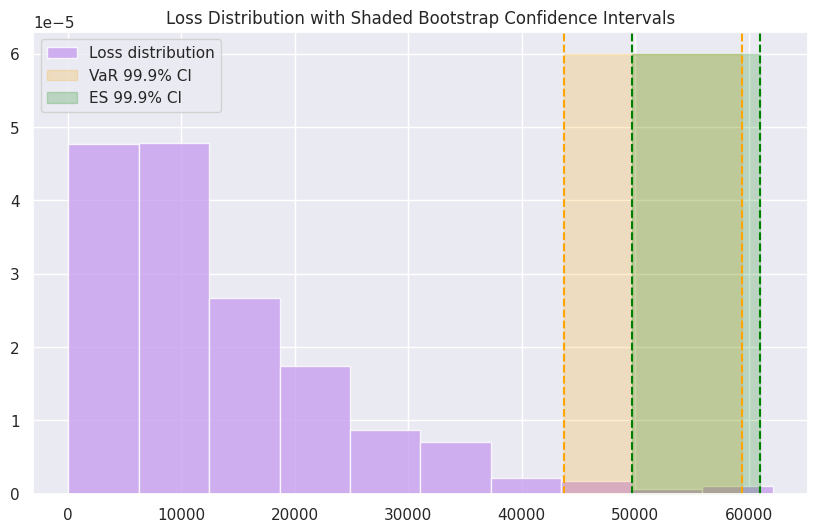

In [24]:
from sklearn.utils import resample

n_bootstrap = 1000
var_b = []
es_b = []

for _ in range(n_bootstrap):
    boot = resample(samples, replace=True, n_samples=len(samples))

    var = np.percentile(boot, 100 * confidence_level)

    es = boot[boot > var].mean()

    var_b.append(var)
    es_b.append(es)

# Bootstrap confidence intervals
var_ci = np.percentile(var_b, [0.1, 99.9])
es_ci  = np.percentile(es_b, [0.1, 99.9])

print("VaR 99.9% CI:", var_ci)
print("ES 99.9% CI:", es_ci)

plt.figure(figsize=(10,6))
plt.hist(samples,histtype="barstacked", color="#C79FEF", bins=10, alpha=0.8, density=True, label="Loss distribution")
plt.axvline(var_ci[0], color="orange", linestyle="--")
plt.axvline(var_ci[1], color="orange", linestyle="--")
plt.axvline(es_ci[0], color="green", linestyle="--")
plt.axvline(es_ci[1], color="green", linestyle="--")
plt.fill_betweenx(
    y=[0, 0.00006],  # adjust y-limits to match histogram density
    x1=var_ci[0],
    x2=var_ci[1],
    color="orange",
    alpha=0.2,
    label="VaR 99.9% CI"
)

plt.fill_betweenx(
    y=[0, 0.00006],
    x1=es_ci[0],
    x2=es_ci[1],
    color="green",
    alpha=0.2,
    label="ES 99.9% CI"
)

plt.legend()
plt.title("Loss Distribution with Shaded Bootstrap Confidence Intervals")
plt.show()




As we could see above, the VaR is between 43759.39 and 59392.80 indicating that the maximum expected loss for operational risks can fall in that bound.

They gather insights about the risk capital requirements for the operational risk.

The ES is more severe, letting look the tail.
It is between 49690.45 and 60996.56.

The plot below gives only one value for the value at risk and the expected shortfall.

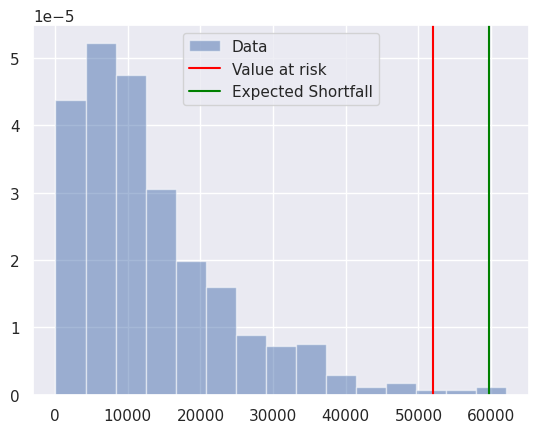

In [20]:
plt.hist(samples, bins=15, density=True, alpha=0.5, label='Data')
plt.axvline(value_at_risk, label="Value at risk", color="red")
plt.axvline(es, label="Expected Shortfall", color="green")
plt.legend()
plt.show()

#Mean loss function and mean excess function

The **Mean Excess Function (MEF)** and the **Mean Loss Function (MLF)** are important tools in operational risk analysis for characterizing the tail behavior of loss distributions beyond traditional measures like VaR and ES.

### Mean Excess Function (MEF)

- **Definition**: The MEF at a threshold $u$ is defined as the expected loss **exceeding** $u$, conditional on the loss being greater than $u$:
  $
  e(u) = E[X - u \mid X > u]
  $
- **Interpretation**: It measures the average amount by which losses exceed the threshold $u$. If $u$ is set high (e.g., near the VaR), the MEF tells you how severe losses are once they cross that extreme level.
- **Use in Operational Risk**:
  - Helps understand the severity of tail losses above a given threshold.
  - Can be used for selecting thresholds in Peak Over Threshold (POT) models in Extreme Value Theory.
  - A convex increasing MEF indicates a heavy-tailed distribution, suggesting potential for very large operational losses.

### Mean Loss Function (MLF)

- **Definition**: The MLF at a threshold $u$ calculates the **average loss clipped at $u$**, essentially:
  $
  m(u) = E[\max(X - u, 0)]
  $
- **Interpretation**: It gives the expected loss amount beyond $u$, counting zero if the loss does not exceed $u$. While similar to MEF, it incorporates losses exactly at or below the threshold as zero.
- **Use in Operational Risk**:
  - Quantifies expected excess loss above a tolerance level.
  - Helpful in setting operational risk limits or reserves for losses above certain levels.

### Practical Meaning in Your Context

- By calculating the MEF and MLF at a chosen threshold (e.g., €5,000), you gain deeper insights into the **tail risk dynamics** of your operational loss distribution.
- While VaR reports a cutoff loss level, MEF and MLF describe **how bad losses beyond that cutoff can get on average**.
- These functions complement VaR and ES by providing richer statistical properties of losses, helping to design better risk mitigation strategies and capital buffers.



In [33]:
threshold= [1500,3000,4000,5000]
mean_excess_function=np.zeros(len(threshold))
mean_loss_function=np.zeros(len(threshold))

for idx,i in enumerate(threshold):

  mean_excess_function[idx]= samples[samples > i].mean()
  mean_loss_function[idx]=np.maximum(samples - i,0).mean()
  print(f'Done with {i}')


Done with 1500
Done with 3000
Done with 4000
Done with 5000


In [34]:
mean_excess_function

array([13928.50442561, 14945.59213207, 15537.84664231, 16454.56795129])

In [35]:
mean_loss_function

array([11807.07920433, 10440.44752343,  9587.95055976,  8785.65361864])

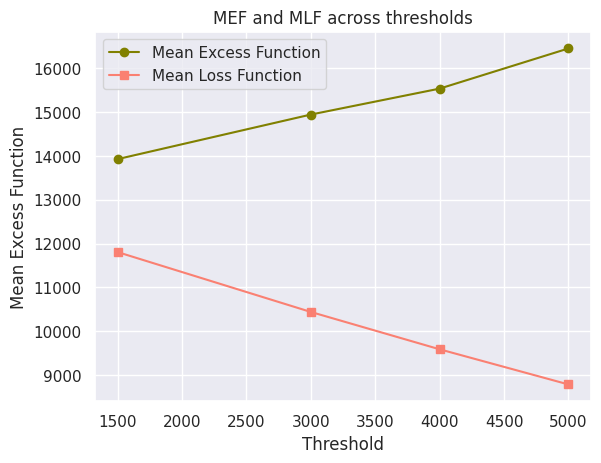

In [42]:
plt.plot(threshold, mean_excess_function,marker="o", label="Mean Excess Function", color="olive")
plt.xlabel("Threshold")
plt.ylabel("Mean Excess Function")
plt.plot(threshold, mean_loss_function, marker="s",label="Mean Loss Function", color="salmon")
plt.title("MEF and MLF across thresholds")
plt.legend()
plt.show()

The plot above shows the MEF and MLF across different thresholds.
The MLF is decreasing with the increasing of the thresholds; the MEF is increasing with the increasing of the thresholds.
As the threshold increases, fewer losses exceed it, so the average expected loss beyond the higher threshold decreases because:

* More data points fall below the threshold and contribute zero to the average.

* The number of exceedances shrinks, pulling the average excess down.

> This decreasing trend tells you that the overall mass of losses above very high thresholds is low, reflecting the rarity of extremely large operational losses in the dataset.

The MEF conditions only on losses exceeding the threshold, measuring the average excess severity given exceedance.

* An increasing MEF indicates that once losses cross higher thresholds, the average amount they exceed by also grows.

* This shows the heavy-tailed nature of losses: extreme losses can become substantially larger beyond high thresholds.

> The increasing MEF signals rising tail risk severity for operational losses, meaning risk managers should pay special attention to these tail events despite their low frequency.
